In [1]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [2]:

%pprint
%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

dir()

Pretty printing has been turned OFF
D:\Documents\Repositories\notebooks\covid19\ipynb\World Countries Doubling Wind Release.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '__warningregistry__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_ending_wit

In [3]:

def get_doubling_days(count_yesterday, count_today):
    growth_rate = (count_today-count_yesterday)/count_today
    doubling_days = math.log(2)/growth_rate
    
    return doubling_days


---
# Load the Country Data

In [74]:

columns_list = ['Date', 'Deaths_Cumulative', 'Deaths_Hospital_Cumulative']
dataframes_list = []
for file_name in os.listdir(s.saves_pickle_folder):
    if file_name.endswith('_df.pickle'):
        df_name = file_name.split('.')[0]
        df = eval("s.load_object('{}')".format(df_name))
        if len(set(columns_list) - set(df.columns)) == 1:
            #print("{} = s.load_object('{}')".format(df_name, df_name))
            #print('{}'.format(df_name))
            dataframes_list.append(df_name)

In [75]:

dataframes_list

['arkansas_df', 'california_df', 'colorado_df', 'czech_df', 'florida_df', 'france_df', 'germany_df', 'illinois_df', 'iran_df', 'italy_df', 'new_york_df', 'oregon_df', 'slovakia_df', 'south_carolina_df', 'south_korea_df', 'spain_df', 'tennessee_df', 'uk_df', 'usa_df', 'us_deaths_df', 'vermont_df']

In [77]:

import numpy as np

dataframes_list = ['czech_df', 'france_df', 'germany_df', 'iran_df', 'italy_df', 'slovakia_df',
                   'south_korea_df', 'spain_df', 'uk_df',
                   'usa_df']
countries_list = ['Czechia', 'France', 'Germany', 'Iran (Islamic Republic of)', 'Italy', 'Slovakia',
                  'Korea, Republic of', 'Spain', 'United Kingdom of Great Britain and Northern Ireland',
                  'United States of America']
country_abbreviations_dict = s.load_object('country_abbreviations_dict')
columns_list = ['Date', 'Deaths_Cumulative']
world_countries_df = pd.DataFrame([], columns=columns_list+['Country_Abbreviation'])
for df_name, country_name in zip(dataframes_list, countries_list):
    df = eval("s.load_object('{}')".format(df_name))
    if 'Deaths_Hospital_Cumulative' in df.columns:
        df.rename(columns={'Deaths_Hospital_Cumulative': 'Deaths_Cumulative'}, inplace=True)
    df = df[columns_list]
    df.Deaths_Cumulative.ffill(inplace=True)
    df.Deaths_Cumulative.fillna(value=0, inplace=True)
    df['Country_Abbreviation'] = country_abbreviations_dict[country_name]
    world_countries_df = pd.concat([world_countries_df, df]).reset_index(level=0, inplace=False, drop=True).dropna(axis='index', how='all')
world_countries_df.sample(5)

,Date,Deaths_Cumulative,Country_Abbreviation
243,2020-02-29,17,KR
83,2020-03-01,0,DE
409,2020-02-15,0,US
113,2020-02-25,15,IR
157,2020-03-07,233,IT


In [78]:

from datetime import date

world_countries_df.Date = pd.to_datetime(world_countries_df.Date).map(lambda ts: date(ts.year, ts.month, ts.day))
world_countries_df = world_countries_df.sort_values(['Country_Abbreviation', 'Date'])
world_countries_df.reset_index(level=0, inplace=True, drop=True)
world_countries_df['Deaths_Doubling'] = np.nan
for Country_Abbreviation_name in world_countries_df.Country_Abbreviation.unique():
    mask_series = (world_countries_df.Country_Abbreviation == Country_Abbreviation_name)
    row_index_list = world_countries_df[mask_series].sort_values('Date').index
    for i in range(1, len(row_index_list)):
        row_index = row_index_list[i-1]
        count_yesterday = world_countries_df.loc[row_index, 'Deaths_Cumulative']
        row_index = row_index_list[i]
        count_today = world_countries_df.loc[row_index, 'Deaths_Cumulative']
        try:
            doubling_days = get_doubling_days(count_yesterday, count_today)
            if doubling_days != np.inf:
                world_countries_df.loc[row_index, 'Deaths_Doubling'] = doubling_days
        except ZeroDivisionError as e:
            pass
world_countries_df = world_countries_df.replace([np.inf, -np.inf], np.nan)
s.store_objects(world_countries_df=world_countries_df)
world_countries_df.sample(5)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\world_countries_df.pickle


,Date,Deaths_Cumulative,Country_Abbreviation,Deaths_Doubling
147,2020-03-25,2,FR,NaN
295,2020-03-13,1266,IT,3.510097
92,2020-03-29,7340,ES,6.265641
97,2020-04-03,11744,ES,10.062201
143,2020-03-21,2,FR,NaN


In [79]:

def compare_smoothed(Country_Abbreviation):
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(111, autoscale_on=True)
    Text_obj = ax.set_xlabel('Doubling Period (Days/Smoothed)')
    for column_name in ['Deaths_Doubling', 'DD_Smoothed']:
        mask_series = (world_countries_df.Country_Abbreviation == Country_Abbreviation)
        df = world_countries_df[mask_series].sort_values('Date')
        if 'smoothed' in column_name.lower():
            AxesSubplot_obj = df.plot.scatter(x='Date', y=column_name, ax=ax, label=column_name,
                                              color='red', s=2.0)
        else:
            AxesSubplot_obj = df.plot.line(x='Date', y=column_name, ax=ax, label=column_name)

In [80]:

def f(df):
    columns_list = ['Deaths_Doubling']
    df = df.sort_values('Date', ascending=True)[columns_list]
    #unsmoothed_series = df.Deaths_Doubling
    df = df.interpolate(axis='index', limit_area='inside', inplace=False)
    interpolated_series = df.Deaths_Doubling
    smoothed_series = interpolated_series.rolling(7).mean().combine_first(interpolated_series)
    doublings_series = pd.concat([interpolated_series, smoothed_series], axis=1).min(axis=1)
    
    return smoothed_series

world_countries_df['DD_Smoothed'] = world_countries_df.groupby('Country_Abbreviation').apply(f).reset_index(level=0, drop=True)

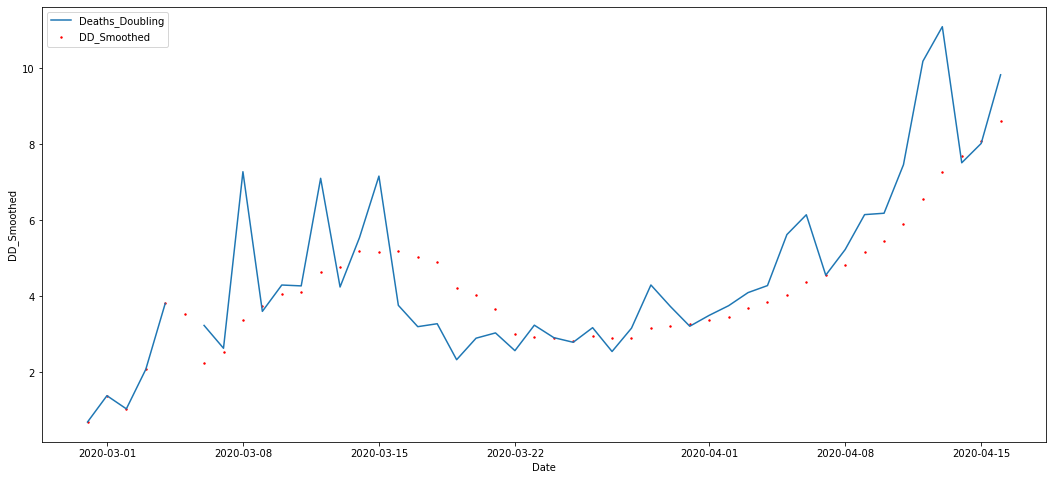

In [81]:

compare_smoothed('US')

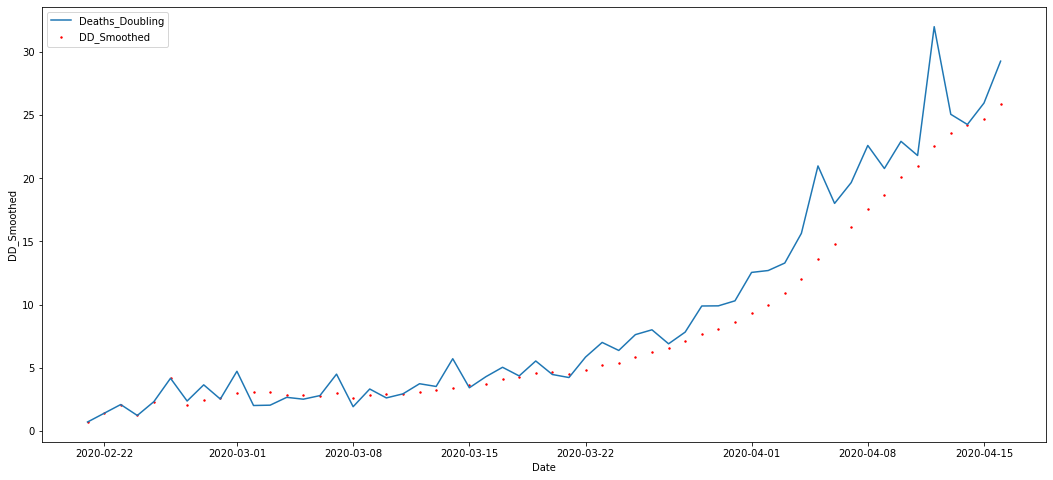

In [82]:

compare_smoothed('IT')

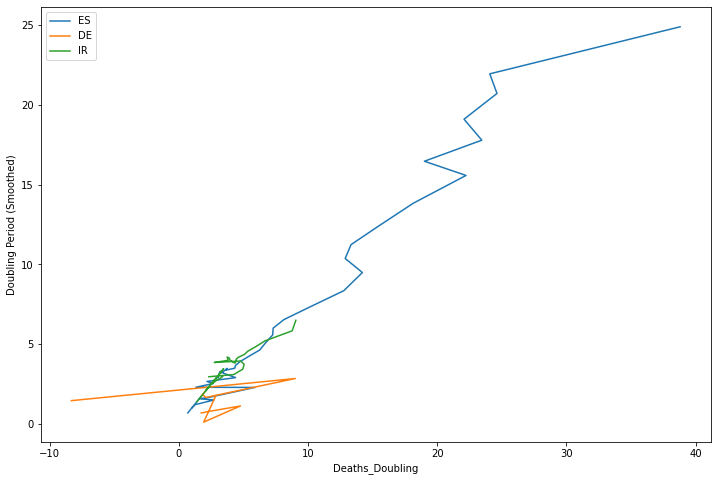

In [83]:

columns_list = ['Deaths_Doubling', 'DD_Smoothed']
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, autoscale_on=True)
Text_obj = ax.set_xlabel('Doubling Period (Days)')
Text_obj = ax.set_ylabel('Doubling Period (Smoothed)')
iso_3166_list = world_countries_df.Country_Abbreviation.unique()
for alpha_2_code in np.random.choice(iso_3166_list, size=3):
    mask_series = (world_countries_df.Country_Abbreviation == alpha_2_code)
    df = world_countries_df[mask_series].sort_values('Date')[columns_list]
    AxesSubplot_obj = df.plot.line(x='Deaths_Doubling', y='DD_Smoothed', ax=ax, label=alpha_2_code)

In [84]:

from matplotlib.patches import Rectangle

xlim_left = -1
xlim_right = 15
ylim_top = 1_000_000
doubling_match_series = (world_countries_df.Deaths_Cumulative > 0) & (world_countries_df.DD_Smoothed > 0)
doubling_match_series = doubling_match_series & (world_countries_df.Deaths_Cumulative <= ylim_top)
doubling_match_series = doubling_match_series & (world_countries_df.DD_Smoothed <= xlim_right)
ylim_bottom = world_countries_df[doubling_match_series].Deaths_Cumulative.min()
png_dir = os.path.join(s.saves_folder, 'png')
dates_list = [date(ts.year, ts.month, ts.day) for ts in pd.date_range(world_countries_df[doubling_match_series].Date.min(),
                                                                      world_countries_df[doubling_match_series].Date.max())]
bottom = 100
red_left = 0
red_kwargs = {'alpha': 0.25, 'edgecolor': 'black', 'facecolor': 'pink',
              'fill': True, 'label': 'Pandemic Zone', 'zorder': 1}
yellow_left = 8
yellow_kwargs = {'alpha': 0.25, 'edgecolor': 'black', 'facecolor': 'yellow',
                 'fill': True, 'label': 'Flattened Zone', 'zorder': 2}

In [92]:

def create_figure(date_obj):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, autoscale_on=False)
    ax.set_yscale('log')
    xlim_tuple = ax.set_xlim(left=xlim_left, right=xlim_right)
    ylim_tuple = ax.set_ylim(bottom=ylim_bottom, top=ylim_top)
    Text_obj = ax.set_xlabel('Doubling Period (Days)')
    Text_obj = ax.set_ylabel('Cumulative Deaths')
    Text_obj = ax.set_title('COVID-19 Outbreak {}'.format(date_obj))
    
    # Danger Zone
    Rectangle_obj = ax.add_patch(Rectangle(xy=(red_left, bottom), width=6,
                                           height=ylim_top-bottom, angle=0.0,
                                           **red_kwargs))
    kwargs = {'horizontalalignment': 'center', 'verticalalignment': 'center',
              'transform': ax.transAxes, 'color': 'red', 'alpha': 1.0}
    fig.text(0.245, 0.95,
             'Danger Zone:\nAlarming Doubling Period and\nHigh number of cumulative deaths',
             **kwargs)
    
    # Flattened Zone
    Rectangle_obj = ax.add_patch(Rectangle(xy=(yellow_left, bottom), width=6,
                                           height=ylim_top-bottom, angle=0.0,
                                           **yellow_kwargs))
    kwargs = {'horizontalalignment': 'center', 'verticalalignment': 'center',
              'transform': ax.transAxes, 'color': 'black', 'alpha': 1.0}
    fig.text(0.745, 0.95,
             'Warning Zone:\nSlowing down the Doubling Period\ndue to Flattening the Curve',
             **kwargs)
    
    return fig, ax

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\color_dict.pickle


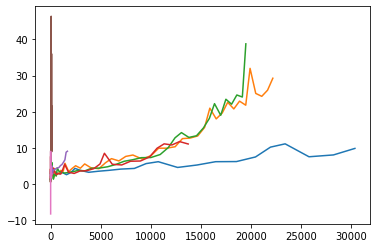

In [93]:

color_dict = {}
for alpha_2_code in world_countries_df.groupby('Country_Abbreviation').Deaths_Cumulative.max().sort_values(ascending=False).index:
    mask_series = (world_countries_df.Country_Abbreviation == alpha_2_code)
    df = world_countries_df[mask_series]
    deaths_series = df.Deaths_Cumulative
    doublings_series = df.Deaths_Doubling
    Line2D_obj = plt.plot(deaths_series, doublings_series, label=alpha_2_code)[0]
    color = Line2D_obj.get_color()
    color_dict[alpha_2_code] = color
s.store_objects(color_dict=color_dict)

In [94]:

world_countries_df.columns

Index(['Date', 'Deaths_Cumulative', 'Country_Abbreviation', 'Deaths_Doubling',
       'DD_Smoothed'],
      dtype='object')

In [95]:

color_dict = s.load_object('color_dict')
for date_obj in dates_list:
    fig, ax = create_figure(date_obj)
    mask_series = (world_countries_df.Date == date_obj) & doubling_match_series
    df = world_countries_df[mask_series].copy()
    for alpha_2_code in df.Country_Abbreviation:
        mask_series = (df.Country_Abbreviation == alpha_2_code)
        deaths_series = df[mask_series].Deaths_Cumulative
        doublings_series = df[mask_series].DD_Smoothed
        kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                      bbox=dict(boxstyle='round,pad=0.5', fc=color_dict[alpha_2_code], alpha=0.5))
        PathCollection_obj = ax.scatter(x=doublings_series, y=deaths_series, s=0.0, c=color_dict[alpha_2_code], alpha=0.0)
        for x, y in zip(doublings_series, deaths_series):
            annotation = plt.annotate('{}'.format(alpha_2_code), xy=(x, y), xytext=(-5, -8), **kwargs)
    file_name = 'fig_{}_{:02d}_{:02d}.png'.format(date_obj.year, date_obj.month, date_obj.day)
    fig.savefig(os.path.join(png_dir, file_name), transparent=False)
    plt.close(fig)

In [96]:

import imageio

# Get images list
images_list = []
for date_obj in dates_list:
    file_name = 'fig_{}_{:02d}_{:02d}.png'.format(date_obj.year, date_obj.month, date_obj.day)
    file_path = os.path.join(png_dir, file_name)
    images_list.append(imageio.imread(file_path))
for i in range(9):
    images_list.append(imageio.imread(file_path))

In [97]:

gif_dir = os.path.join(s.saves_folder, 'gif')
os.makedirs(name=gif_dir, exist_ok=True)
file_path = os.path.join(gif_dir, 'cumulative_deaths_by_country.gif')
kwargs = {'duration': 1}
imageio.mimsave(file_path, images_list, **kwargs)

In [98]:

!"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {os.path.abspath(file_path)}

Opening in existing browser session.

C:\Program Files (x86)\Google\Chrome\Application\chrome.exe: invalid option -- `-u'
Try 'chrome.exe --help' for more information.
[0417/134624.996:ERROR:registration_protocol_win.cc(84)] TransactNamedPipe: The pipe has been ended. (0x6D)
[101500:111372:0417/134625.551:ERROR:cache_util_win.cc(21)] Unable to move the cache: Access is denied. (0x5)
[101500:111372:0417/134625.551:ERROR:cache_util.cc(135)] Unable to move cache folder C:\Users\577342\AppData\Local\Google\Chrome\User Data\ShaderCache\GPUCache to C:\Users\577342\AppData\Local\Google\Chrome\User Data\ShaderCache\old_GPUCache_000
[101500:111372:0417/134625.551:ERROR:disk_cache.cc(184)] Unable to create cache
[101500:111372:0417/134625.551:ERROR:shader_disk_cache.cc(606)] Shader Cache Creation failed: -2


In [15]:

text_editor_path = r'C:\Program Files\Notepad++\notepad++.exe'
!"{text_editor_path}" "{csv_path}"


---